Imports

In [1]:
from nb201 import NB201Benchmark
import numpy as np
from warmstart.utils_templates import FullTemplate
import ConfigSpace as CS
from ConfigSpace import Configuration
import torchvision
import ast
from llambo.llambo import LLAMBO
import openai
from openai import OpenAI
from utils import convert_synetune_dict_to_LLAMBO_dict

from syne_tune_local.experiments.benchmark_definitions.nas201 import nas201_benchmark
from syne_tune_local.blackbox_repository import BlackboxRepositoryBackend
from syne_tune_local.backend.simulator_backend.simulator_callback import SimulatorCallback
from syne_tune_local import Tuner, StoppingCriterion

from typing import Optional, Dict, Any, List, Union
import logging
from syne_tune_local.optimizer.schedulers import FIFOScheduler
from syne_tune_local.optimizer.schedulers.searchers import StochasticAndFilterDuplicatesSearcher

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/e.lushtaku/Library/Application Support/sagemaker/config.yaml
Dependencies of YAHPO are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[yahpo]'
or (for everything)
   pip install 'syne-tune[extra]'
Dependencies of YAHPO are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[yahpo]'
or (for everything)
   pip install 'syne-tune[extra]'


Load NB201 Benchmark

In [2]:
b = NB201Benchmark(path="./nb201.pkl", dataset='cifar10')
cs = b.get_configuration_space()

print('cs: ', cs)

cs:  Configuration space object:
  Hyperparameters:
    op_0_to_1, Type: Categorical, Choices: {none, skip_connect, avg_pool_3x3, nor_conv_1x1, nor_conv_3x3}, Default: none
    op_0_to_2, Type: Categorical, Choices: {none, skip_connect, avg_pool_3x3, nor_conv_1x1, nor_conv_3x3}, Default: none
    op_0_to_3, Type: Categorical, Choices: {none, skip_connect, avg_pool_3x3, nor_conv_1x1, nor_conv_3x3}, Default: none
    op_1_to_2, Type: Categorical, Choices: {none, skip_connect, avg_pool_3x3, nor_conv_1x1, nor_conv_3x3}, Default: none
    op_1_to_3, Type: Categorical, Choices: {none, skip_connect, avg_pool_3x3, nor_conv_1x1, nor_conv_3x3}, Default: none
    op_2_to_3, Type: Categorical, Choices: {none, skip_connect, avg_pool_3x3, nor_conv_1x1, nor_conv_3x3}, Default: none



Arguments for LLAMBO

In [3]:
task_context = {
    'model': 'CNN',
    'task': 'classification',
    'metric': 'validation_loss',
    'num_samples': 50000,
    'image_size': 'height 32, width 32, and 3 channels',
    'num_feat': 32 * 32 * 3,
    'tot_feats': 32 * 32 * 3,
    'cat_feats': 0,
    'n_classes': 10,
    'lower_is_better': True,
    'hyperparameter_constraints': {
        'op_0_to_1': ['categorical', None, ["none", "skip_connect", "avg_pool_3x3", "nor_conv_1x1", "nor_conv_3x3"]],
        # [type, transform, [min_value, max_value]]
        'op_0_to_2': ['categorical', None, ["none", "skip_connect", "avg_pool_3x3", "nor_conv_1x1", "nor_conv_3x3"]],
        'op_0_to_3': ['categorical', None, ["none", "skip_connect", "avg_pool_3x3", "nor_conv_1x1", "nor_conv_3x3"]],
        'op_1_to_2': ['categorical', None, ["none", "skip_connect", "avg_pool_3x3", "nor_conv_1x1", "nor_conv_3x3"]],
        'op_1_to_3': ['categorical', None, ["none", "skip_connect", "avg_pool_3x3", "nor_conv_1x1", "nor_conv_3x3"]],
        'op_2_to_3': ['categorical', None, ["none", "skip_connect", "avg_pool_3x3", "nor_conv_1x1", "nor_conv_3x3"]]
    }
}


def eval_point(config):
    new_config = Configuration(b.get_configuration_space(), values=config)
    res = b.objective_function(new_config)
    res_dict = {
        "score": res[0],
        "train_time": res[1]
    }
    return config, res_dict

Statistics

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)


def fetch_statistics(dict, dataset):
    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    images = dataset.data
    labels = dataset.targets

    images_np = np.array(images)
    labels_np = np.array(labels)

    pixel_mean = np.mean(images_np / 255.)
    pixel_std = np.std(images_np / 255.)

    class_counts = np.bincount(labels_np)
    class_distribution = class_counts / len(labels_np)

    # Constructing the descriptive string for class distribution with class names
    class_distribution_str = ", ".join(
        f"{distribution * 100:.2f}% of datapoints belong to class {labels_np[i]}: {class_names[i]}"
        for i, distribution in enumerate(class_distribution) if i < len(labels_np)
    )
    print('class_distribution_str', class_distribution_str)
    dict['pixel_mean'] = pixel_mean
    dict['pixel_std'] = pixel_std
    dict['class_distribution'] = class_distribution_str

    return dict


task_context = fetch_statistics(task_context, trainset)

Files already downloaded and verified
class_distribution_str 10.00% of datapoints belong to class 6: Airplane, 10.00% of datapoints belong to class 9: Automobile, 10.00% of datapoints belong to class 9: Bird, 10.00% of datapoints belong to class 4: Cat, 10.00% of datapoints belong to class 1: Deer, 10.00% of datapoints belong to class 1: Dog, 10.00% of datapoints belong to class 2: Frog, 10.00% of datapoints belong to class 7: Horse, 10.00% of datapoints belong to class 8: Ship, 10.00% of datapoints belong to class 3: Truck


Warmstart

In [5]:
context = "Full_Context"


def extract_configs_from_response(response):
    content = response.choices[0].message.content
    start = content.find("[")
    end = content.rfind("]") + 1
    list_str = content[start:end]
    configurations = ast.literal_eval(list_str)
    return configurations


def is_dict_valid_in_config_space(d, config_space):
    try:
        # Attempt to create a Configuration object with the given dictionary and config space
        config = CS.Configuration(config_space, values=d)
        return True
    except:
        # Return False if the dictionary is not valid
        return False
    # Function to check if all dictionaries in a list are valid in the given configuration space


def check_all_list(parsed_dicts, config_space):
    for idx, d in enumerate(parsed_dicts):
        if not is_dict_valid_in_config_space(d, config_space):
            return False
    return True


def obtain_all_list_valid(resp, config_space):
    if check_all_list(resp, config_space):
        return resp
    print("fail")


def generate_init_conf(n_samples, client):
    template_object = FullTemplate(context=context, provide_ranges=True)
    user_message = template_object.add_context(config_space=cs, num_recommendation=n_samples, task_dict=task_context)
    messages = []
    messages.append({"role": "system", "content": "You are an AI assistant that helps people find information."})
    messages.append({"role": "user", "content": user_message})

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0.7,
        max_tokens=4000,
        top_p=0.95,
        n=max(5, 3),  # e.g. for 5 templates, get 2 generations per template
        timeout=100
    )
    configs = extract_configs_from_response(response)
    return obtain_all_list_valid(configs, cs)

#print(generate_init_conf(3))

Llambo

In [6]:
client = OpenAI(
    organization='org-HIWwqsnxyBU3xMl6PkwdjxdN',
    project='proj_g30ZlMFGBNu4qsUctIhNI5B3',
    api_key='sk-proj-cTiFSkfqsowfmg6FId0iT3BlbkFJfDi43ms9k13R9bKElYE1'
)

llambo = LLAMBO(task_context, sm_mode='discriminative', n_candidates=10, n_templates=2, n_gens=6,
                alpha=0.1, n_initial_samples=5, n_trials=4,
                init_f=generate_init_conf,
                bbox_eval_f=eval_point,
                chat_engine="gpt-4o-mini",
                client=client)
llambo.seed = 0

# run optimization
#configs, fvals = llambo.optimize(test_metric="score")

[Search settings]: 
	n_candidates: 10, n_templates: 2, n_gens: 6, 
	alpha: 0.1, n_initial_samples: 5, n_trials: 4, 
	using warping: False, ablation: None, shuffle_features: False
[Task]: 
	task type: classification, sm: discriminative, lower is better: True
Hyperparameter search space: 
{'op_0_to_1': ['categorical',
               None,
               ['none',
                'skip_connect',
                'avg_pool_3x3',
                'nor_conv_1x1',
                'nor_conv_3x3']],
 'op_0_to_2': ['categorical',
               None,
               ['none',
                'skip_connect',
                'avg_pool_3x3',
                'nor_conv_1x1',
                'nor_conv_3x3']],
 'op_0_to_3': ['categorical',
               None,
               ['none',
                'skip_connect',
                'avg_pool_3x3',
                'nor_conv_1x1',
                'nor_conv_3x3']],
 'op_1_to_2': ['categorical',
               None,
               ['none',
                'skip_

Searcher

In [7]:
from utils import convert_LLAMBO_df_to_synetune_dict, convert_LLAMBO_dict_to_synetune_dict

logger = logging.getLogger(__name__)

MAX_RETRIES = 100


class LlamboSearcher(StochasticAndFilterDuplicatesSearcher):

    def __init__(
            self,
            config_space: Dict[str, Any],
            metric: Union[List[str], str],
            points_to_evaluate: Optional[List[dict]] = None,
            **kwargs,
    ):
        super().__init__(
            config_space,
            metric=metric,
            points_to_evaluate=points_to_evaluate,
            **kwargs,
        )
        self.X = []
        self.y = []

    def configure_scheduler(self, scheduler):
        from syne_tune_local.optimizer.schedulers.scheduler_searcher import (
            TrialSchedulerWithSearcher,
        )

        assert isinstance(
            scheduler, TrialSchedulerWithSearcher
        ), "This searcher requires TrialSchedulerWithSearcher scheduler"
        super().configure_scheduler(scheduler)

    def _train_model(self, train_data: np.ndarray, train_targets: np.ndarray) -> bool:
        """
        :param train_data: Training input feature matrix X
        :param train_targets: Training targets y
        :return: Was training successful?
        """
        llambo._update_observations(train_data, train_targets)
        return True
    
    def get_state(self) -> Dict[str, Any]:
        return dict(
            super().get_state(),
        )

    def _restore_from_state(self, state: Dict[str, Any]):
        super()._restore_from_state(state)

    def get_config(self, **kwargs) -> Optional[Dict[str, Any]]:
        suggestion = self._next_initial_config()
        if suggestion is None:
            if self.y:
                if self._train_model(np.array(self.X), np.array(self.y)):
                    new_llambo_config = llambo.get_config()
                    if new_llambo_config is not None:
                        suggestion = convert_LLAMBO_df_to_synetune_dict(new_llambo_config)
                        
                if suggestion is None:
                    suggestion = convert_LLAMBO_dict_to_synetune_dict(cs.sample_configuration())
            
        return suggestion
        
    def _update(self, trial_id: str, config: Dict[str, Any], result: Dict[str, Any]):
        self.X.append(convert_synetune_dict_to_LLAMBO_dict(config))
        self.y.append(result)
        
    def clone_from_state(self, state: Dict[str, Any]):
        raise NotImplementedError


In [8]:

logger = logging.getLogger(__name__)

MAX_RETRIES = 100


class MultiFidelityLLamboSearcher(LlamboSearcher):

    def __init__(
            self,
            config_space: Dict[str, Any],
            metric: Union[List[str], str],
            points_to_evaluate: Optional[List[dict]] = None,
            resource_attr: Optional[str] = None,
            **kwargs,
    ):
        super().__init__(
            config_space,
            metric=metric,
            points_to_evaluate=points_to_evaluate,
            **kwargs,
        )
        self.resource_attr = resource_attr
        self.resource_levels = []

    def configure_scheduler(self, scheduler):
        from syne_tune_local.optimizer.schedulers.multi_fidelity import (
            MultiFidelitySchedulerMixin,
        )

        super().configure_scheduler(scheduler)
        assert isinstance(
            scheduler, MultiFidelitySchedulerMixin
        ), "This searcher requires MultiFidelitySchedulerMixin scheduler"
        self.resource_attr = scheduler.resource_attr
       
    def _train_model(self, train_data: np.ndarray, train_targets: np.ndarray) -> bool:
        highest_resource_level = self._highest_resource_model_can_fit()
        if highest_resource_level is None:
            return False
        else:
            indices = np.where(self.resource_levels == highest_resource_level)
            sub_data = train_data[indices]
            sub_targets = train_targets[indices]
        return super()._train_model(sub_data, sub_targets)
     
    def _highest_resource_model_can_fit(self) -> Optional[int]:
        # find the highest resource level we have at least one data points of the positive class
        min_data_points = 4
        unique_resource_levels, counts = np.unique(
            self.resource_levels, return_counts=True
        )
        idx = np.where(counts >= min_data_points)[0]

        if len(idx) == 0:
            return None

        # collect data on the highest resource level
        return unique_resource_levels[idx[-1]]
    
    def get_state(self) -> Dict[str, Any]:
        return dict(
            super().get_state(),
        )

    def _restore_from_state(self, state: Dict[str, Any]):
        super()._restore_from_state(state)

    def _update(self, trial_id: str, config: Dict, result: Dict):
        super()._update(trial_id=trial_id, config=config, result=result)
        resource_level = int(result[self.resource_attr])
        self.resource_levels.append(resource_level)


Simple searcher combined with LLAMBO

In [9]:
from syne_tune_local.optimizer.schedulers.synchronous import SynchronousGeometricHyperbandScheduler

logging.getLogger().setLevel(logging.WARNING)

random_seed = 1
nb201_random_seed = 0
n_workers = 1
dataset_name = "cifar10"
benchmark = nas201_benchmark(dataset_name)

max_resource_attr = benchmark.max_resource_attr
trial_backend = BlackboxRepositoryBackend(
    blackbox_name=benchmark.blackbox_name,
    elapsed_time_attr=benchmark.elapsed_time_attr,
    max_resource_attr=max_resource_attr,
    dataset=dataset_name,
    seed=nb201_random_seed,
)

blackbox = trial_backend.blackbox
nas_configuration_space = blackbox.configuration_space_with_max_resource_attr(
    max_resource_attr,
)

points_to_evaluate = llambo.initialize_configs(5)
points_to_evaluate = convert_LLAMBO_df_to_synetune_dict(points_to_evaluate)
scheduler = SynchronousGeometricHyperbandScheduler(
    config_space=nas_configuration_space,
    max_resource_attr=max_resource_attr,
    mode=benchmark.mode,
    metric=benchmark.metric,
    random_seed=random_seed,
    searcher=MultiFidelityLLamboSearcher,
    resource_attr=blackbox.fidelity_name(),
    points_to_evaluate=points_to_evaluate,
    grace_period=1,
    max_resource_level=81,
)

max_num_trials_started = 150
stop_criterion = StoppingCriterion(max_num_trials_started=max_num_trials_started)

print_update_interval = 700
results_update_interval = 300
tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
    sleep_time=0,
    results_update_interval=results_update_interval,
    print_update_interval=print_update_interval,
    callbacks=[SimulatorCallback()],
)

tuner.run()

Adjusted alpha: 0.1 | [original alpha: 0.1], desired fval: 0.608610
EXAMPLE ACQUISITION PROMPT
Length of prompt templates: 2
Length of query templates: 2
The following are examples of performance of a CNN measured in validation_loss and the corresponding model architecture configurations. The model is evaluated on a image classification task containing 10 classes. The dataset contains 50000 images and each image has height 32, width 32, and 3 channels. The allowable choices for the architectures are:
- op_0_to_1: [none, skip_connect, avg_pool_3x3, nor_conv_1x1, nor_conv_3x3] (categorical)
- op_0_to_2: [none, skip_connect, avg_pool_3x3, nor_conv_1x1, nor_conv_3x3] (categorical)
- op_0_to_3: [none, skip_connect, avg_pool_3x3, nor_conv_1x1, nor_conv_3x3] (categorical)
- op_1_to_2: [none, skip_connect, avg_pool_3x3, nor_conv_1x1, nor_conv_3x3] (categorical)
- op_1_to_3: [none, skip_connect, avg_pool_3x3, nor_conv_1x1, nor_conv_3x3] (categorical)
- op_2_to_3: [none, skip_connect, avg_pool_3

In [10]:
# import logging
# import os
# 
# from syne_tune.experiments.benchmark_definitions import nas201_benchmark
# from syne_tune.backend.simulator_backend.simulator_callback import SimulatorCallback
# from syne_tune.blackbox_repository.simulated_tabular_backend import BlackboxRepositoryBackend
# from syne_tune.optimizer.baselines import (
#     ASHA,
#     SyncBOHB,
#     SyncMOBSTER,
#     DEHB,
# )
# from syne_tune import Tuner, StoppingCriterion
# 
# 
# # class CustomStoreResultsCallback:
# #     def __init__(self, results_dir):
# #         self.results_dir = results_dir
# #         os.makedirs(results_dir, exist_ok=True)
# #
# #     def on_tuning_start(self, tuner):
# #         logging.info(f"Tuning started for {tuner.tuner_name}")
# #
# #     def on_trial_result(self, trial_id, config, result, **kwargs):
# #         result_file = os.path.join(self.results_dir, f"{trial_id}.json")
# #         with open(result_file, 'a') as f:
# #             f.write(f"{result}\n")
# #
# #     def on_tuning_end(self):
# #         logging.info("Tuning ended")
# 
# 
# 
# random_seed = 31415927
# experiment_tag = "HPOs"
# dataset = "cifar10"
# methods = ["ASHA-PROM", "BOHB", "DEHB", "SYNCMOBSTER"]
# 
# logging.getLogger().setLevel(logging.INFO)
# 
# benchmark = nas201_benchmark(dataset)
# max_resource_attr = benchmark.max_resource_attr
# trial_backend = BlackboxRepositoryBackend(
#     elapsed_time_attr=benchmark.elapsed_time_attr,
#     max_resource_attr=max_resource_attr,
#     blackbox_name=benchmark.blackbox_name,
#     dataset=benchmark.dataset_name,
#     surrogate=benchmark.surrogate,
#     surrogate_kwargs=benchmark.surrogate_kwargs,
# )
# 
# blackbox = trial_backend.blackbox
# method_kwargs = dict(
#     metric=benchmark.metric,
#     mode=benchmark.mode,
#     resource_attr=blackbox.fidelity_name(),
#     random_seed=random_seed,
#     max_resource_attr=max_resource_attr,
# )
# config_space = blackbox.configuration_space_with_max_resource_attr(max_resource_attr)
# 
# results_dir = "synetune_results"
# os.makedirs(results_dir, exist_ok=True)
# 
# for method in methods:
#     scheduler = None
#     if method == "ASHA-PROM":
#         scheduler = ASHA(
#             config_space,
#             type="promotion",
#             **method_kwargs,
#         )
#     elif method == "SYNCMOBSTER":
#         scheduler = SyncMOBSTER(
#             config_space,
#             **method_kwargs,
#         )
#     elif method == "BOHB":
#         scheduler = SyncBOHB(
#             config_space,
#             **method_kwargs,
#         )
#     elif method == "DEHB":
#         scheduler = DEHB(
#             config_space,
#             **method_kwargs,
#         )
# 
#     stop_criterion = StoppingCriterion(
#         max_wallclock_time=benchmark.max_wallclock_time,
#         max_num_evaluations=benchmark.max_num_evaluations,
#     )
# 
#     tuner = Tuner(
#         trial_backend=trial_backend,
#         scheduler=scheduler,
#         stop_criterion=stop_criterion,
#         n_workers=4,
#         sleep_time=0,
#         tuner_name=experiment_tag,
#         callbacks=[SimulatorCallback()],
#         metadata={
#             "seed": random_seed,
#             "algorithm": method,
#             "tag": experiment_tag,
#             "benchmark": "nas201-" + dataset,
#         },
#     )
# 
#     tuner.run()
# 
# 


In [11]:
# from typing import Dict, Any, Optional
# import logging
# 
# from syne_tune_local.benchmarking.examples.benchmark_hypertune.baselines import methods
# from syne_tune.experiments import ComparativeResults, PlotParameters, SubplotParameters
# 
# 
# def metadata_to_setup(metadata: Dict[str, Any]) -> Optional[str]:
#     # The setup is the algorithm. No filtering
#     return metadata["algorithm"]
# 
# 
# SETUPS_RIGHT = ("ASHA-PROM", "BOHB", "DEHB", "SYNCMOBSTER")
# 
# 
# def metadata_to_subplot(metadata: Dict[str, Any]) -> Optional[int]:
#     return int(metadata["algorithm"] in SETUPS_RIGHT)
# 
# 
# if __name__ == "__main__":
#     logging.getLogger().setLevel(logging.INFO)
#     experiment_name = "ASHA"
#     experiment_names = ("BOHB", experiment_name, "DEHB")
#     setups = list(methods.keys())
#     num_runs = 15
#     download_from_s3 = False  # Set ``True`` in order to download files from S3
#     # Plot parameters across all benchmarks
#     plot_params = PlotParameters(
#         xlabel="wall-clock time",
#         aggregate_mode="iqm_bootstrap",
#         grid=True,
#     )
#     # We would like two subplots (1 row, 2 columns), with MOBSTER and HYPERTUNE
#     # results on the left, and the remaining baselines on the right. Each
#     # column gets its own title, and legends are shown in both
#     plot_params.subplots = SubplotParameters(
#         nrows=1,
#         ncols=2,
#         kwargs=dict(sharey="all"),
#         titles=["Model-based Methods", "Baselines"],
#         legend_no=[0, 1],
#     )
#     # The creation of ``results`` downloads files from S3 (only if
#     # ``download_from_s3 == True``), reads the metadata and creates an inverse
#     # index. If any result files are missing, or there are too many of them,
#     # warning messages are printed
#     results = ComparativeResults(
#         experiment_names=experiment_names,
#         num_runs=num_runs,
#         setups=setups,
#         metadata_to_setup=metadata_to_setup,
#         plot_params=plot_params
#     )
#     # We can now create plots for the different benchmarks
#     benchmark_name = "nas201-cifar10"
#     benchmark = nas201_benchmark(dataset)
#     # These parameters overwrite those given at construction
#     plot_params = PlotParameters(
#         metric=benchmark.metric,
#         mode=benchmark.mode,
#         ylim=(0.265, 0.31),
#     )
#     results.plot(
#         benchmark_name=benchmark_name,
#         plot_params=plot_params,
#         file_name=f"./{experiment_name}-{benchmark_name}.png",
#     )

In [12]:
# import os
# import pandas as pd
# from matplotlib import pyplot as plt
# import zipfile
# 
# results_dir = "synetune_results"
# results = []
# methods = ["ASHA", "BOHB", "DEHB"]
# results_by_method = {
#     "ASHA": [],
#     "BOHB": [],
#     "DEHB": [],
#     # "SyncMOBSTER": []
# }
# 
# def extract_csv_from_zip(zip_path):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         csv_files = [name for name in zip_ref.namelist() if name.endswith('.csv')]
#         dfs = []
#         for csv_file in csv_files:
#             with zip_ref.open(csv_file) as f:
#                 df = pd.read_csv(f)
#                 dfs.append(df)
#         return pd.concat(dfs, ignore_index=True)
# 
# i = 0
# for root, dirs, files in os.walk(results_dir):
#     for file_name in files:
#         if file_name.endswith(".zip"):
#             zip_path = os.path.join(root, file_name)
#             df = extract_csv_from_zip(zip_path)
#             if i < len(methods):
#                 df['method'] = methods[i]
#                 results_by_method[methods[i]].append(df)
#                 i+= 1
#             break
# 
# 
# for method in results_by_method:
#     results_by_method[method] = pd.concat(results_by_method[method], ignore_index=True)
# 
# plt.figure(figsize=(12, 8))
# for method_name, data in results_by_method.items():
#     plt.plot(
#         data['metric_elapsed_time'],
#         data['metric_valid_error'],
#         label=method_name
#     )
# 
# plt.xlabel('Elapsed Time')
# plt.ylabel('Validation Loss')
# plt.title('HPO Methods Comparison on NAS-Bench-201')
# plt.legend()
# plt.grid(True)
# plt.show()


In [13]:
# from syne_tune.experiments import load_experiment
# 
# 
# if __name__ == "__main__":
#     # Replace with name for your experiment:
#     # Run:
#     #    ls ~/syne-tune/docs-1/MOBSTER-JOINT-0/
#     tuner_name = (
#         "method-experiment-2024-07-26-13-00-12-665"
#     )
# 
#     tuning_experiment = load_experiment(tuner_name)
#     print(tuning_experiment)
# 
#     print(f"best result found: {tuning_experiment.best_config()}")
# 
#     tuning_experiment.plot()

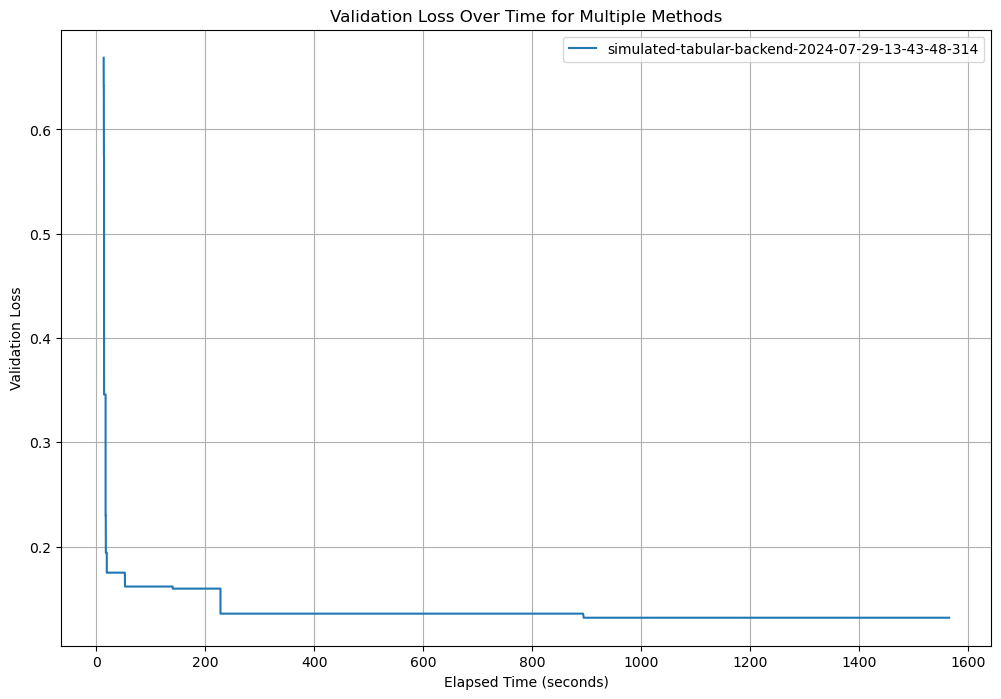

In [20]:
from syne_tune.experiments import load_experiment
import matplotlib.pyplot as plt
import pandas as pd

experiment_names = [
    "simulated-tabular-backend-2024-07-29-13-43-48-314"
]

experiments = {name: load_experiment(name) for name in experiment_names}

results = []

plt.figure(figsize=(12, 8))

for name, experiment in experiments.items():
    df = experiment.results
    if df is not None and len(df) > 0:
        metric_name, metric_mode = experiment._metric_name_mode(0)
        df = df.sort_values("metric_elapsed_time")
        x = df["metric_elapsed_time"]
        y = df[metric_name].cummax() if metric_mode == "max" else df[metric_name].cummin()
        plt.plot(x, y, label=name, linestyle='-')

plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time for Multiple Methods')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1280x960 with 0 Axes>

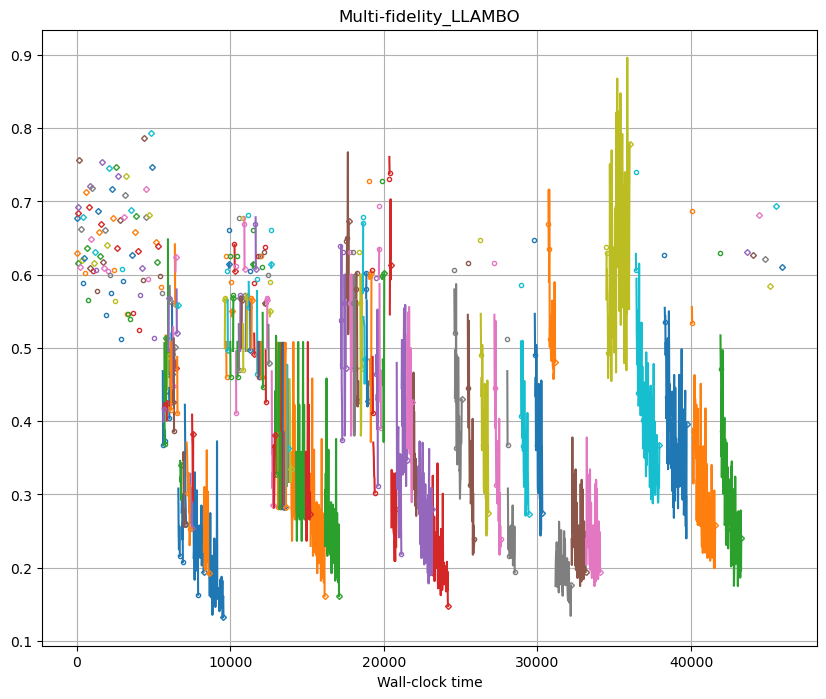

In [3]:
from typing import Dict, Any, Optional

from syne_tune_local.experiments import (
    TrialsOfExperimentResults,
    PlotParameters,
    MultiFidelityParameters,
)
from syne_tune_local.benchmarking.examples.benchmark_hypertune.benchmark_definitions import (
    benchmark_definitions,
)

SETUPS_TO_COMPARE = ({"Multi-fidelity_LLAMBO"})


def metadata_to_setup(metadata: Dict[str, Any]) -> Optional[str]:
    algorithm = metadata["algorithm"]
    return algorithm if algorithm in SETUPS_TO_COMPARE else None


if __name__ == "__main__":
    experiment_name = "simulated-tabular-backend-2024-07-29-13-43-48-314"
    benchmark_name_to_plot = "nas201-cifar10"
    seed_to_plot = 7
    download_from_s3 = False  # Set ``True`` in order to download files from S3

    experiment_names = (experiment_name,)
    # Plot parameters across all benchmarks
    plot_params = PlotParameters(
        xlabel="Wall-clock time",
        grid=True,
    )
    # We need to provide details about rung levels of the multi-fidelity methods.
    # Also, all methods compared are pause-and-resume
    multi_fidelity_params = MultiFidelityParameters(
        rung_levels=[1, 3, 9, 27, 81],
        multifidelity_setups={name: True for name in SETUPS_TO_COMPARE},
    )
    # The creation of ``results`` downloads files from S3 (only if
    # ``download_from_s3 == True``), reads the metadata and creates an inverse
    # index. If any result files are missing, or there are too many of them,
    # warning messages are printed
    results = TrialsOfExperimentResults(
        experiment_names=experiment_names,
        setups=SETUPS_TO_COMPARE,
        metadata_to_setup=metadata_to_setup,
        plot_params=plot_params,
        multi_fidelity_params=multi_fidelity_params,
        download_from_s3=download_from_s3,
        benchmark_key=None,
        seed_key=None,
    )

    # Create plot for certain benchmark and seed
    benchmark = benchmark_definitions[benchmark_name_to_plot]
    # These parameters overwrite those given at construction
    plot_params = PlotParameters(
        metric=benchmark.metric,
        mode=benchmark.mode,
        convert_to_min=True,
    )
    results.plot(
        benchmark_name=benchmark_name_to_plot,
        plot_params=plot_params,
        file_name=f"./learncurves-{experiment_name}-{benchmark_name_to_plot}.png",
    )